In [1]:
import torch
import random
import matplotlib.pyplot as plt
from PIL import Image
import copy
from torch.utils.data import Dataset
import zipfile
import torchvision
from torchvision import transforms ,datasets
from pathlib import Path
import os

In [2]:
path = Path('Geo PR Image Classifier')
with zipfile.ZipFile(r'/content/Geo PR Image Classifier.v2i.folder.zip',"r") as zip_obj:
  zip_obj.extractall(path)

In [3]:
for dirpath , dirname,filenames in os.walk(path/"train"/"geophysics",topdown=False):
  for name in filenames:
   os.remove(os.path.join(dirpath, name))

os.rmdir(path/"train"/"geophysics") #Removing this label because only one training sample is present

LOCATION MAP
Random image path: Geo PR Image Classifier/train/LOCATION MAP/AMX-V_20210426_Amex_Exploration_Reports_on_High_Grade_Zone_and_Denise_with_Results_up_to_10_63_g_t_Au_over__img1_jpg.rf.f2141984fc64306b0c8157264bbd763d.jpg
Image Class:LOCATION MAP
Image height: 640
Image width: 640


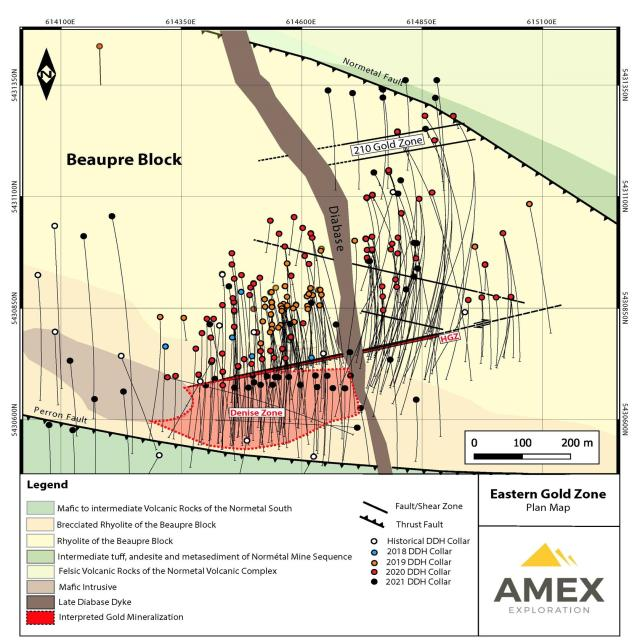

In [ ]:
random.seed(42)
image_path_list = list(path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem
print(image_class)

img = Image.open(random_image_path)

# Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class:{image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img


In [ ]:
data_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    #Resizing image to 224 x 224
    transforms.Resize(size =(224,224)),
    # Turn the image torch.Tensor
    transforms.ToTensor()
])

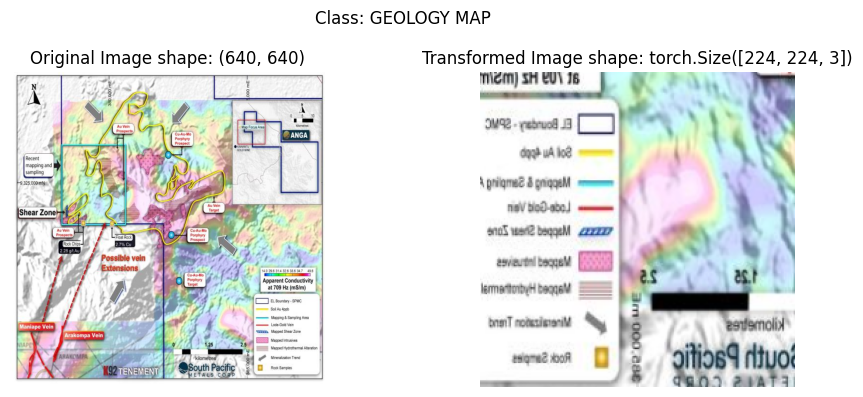

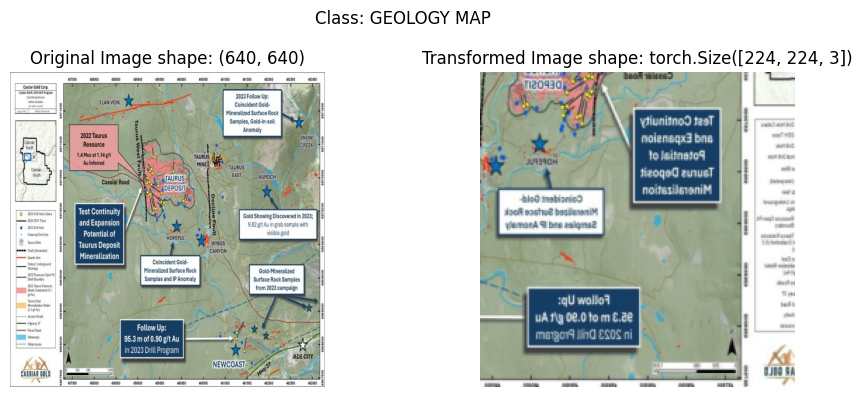

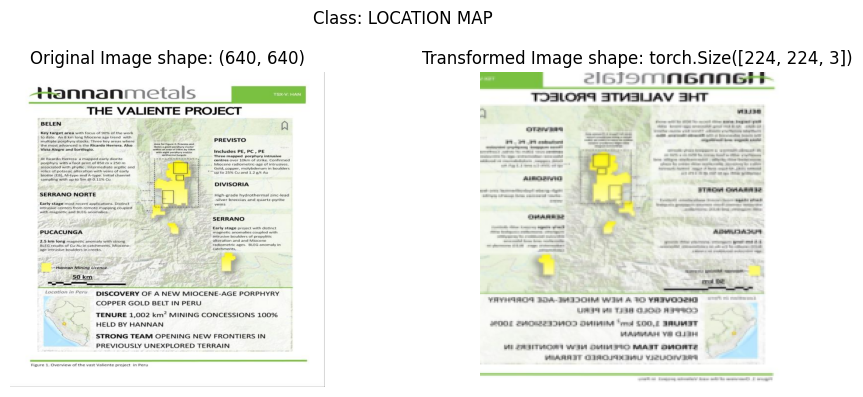

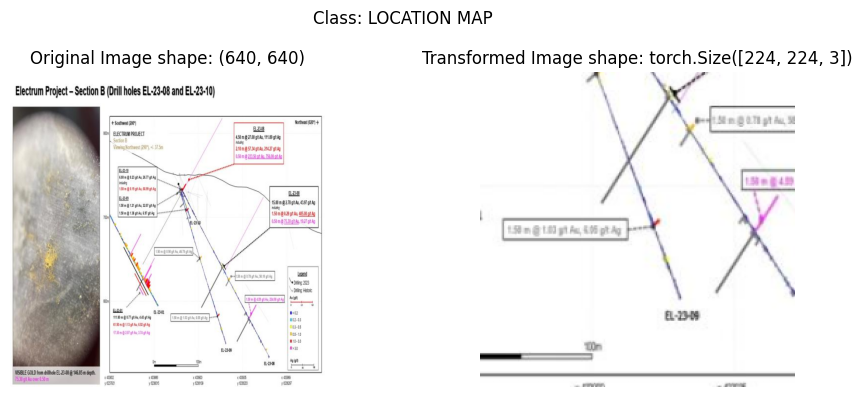

In [ ]:
def plot_original_transformed_image(image_paths,transform,n=3,seed=43):
  """Selecting random images and plotting the original image and transformed image"""
  image_path_list = list(image_paths.glob("*/*/*.jpg"))
  if seed:
    random.seed(seed)
  random_image_path = random.sample(image_path_list ,k=n)
  for image_path in random_image_path:
    with Image.open(image_path) as img:
      fig ,ax = plt.subplots(figsize=(10,4),nrows=1,ncols=2)
      ax[0].imshow(img)
      ax[0].set_title(f"Original Image shape: {img.size}")
      ax[0].axis(False)

      #plotting transformed image
      transformed_image= transform(img).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed Image shape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}")
      plt.tight_layout()

plot_original_transformed_image(
    image_paths = path,
    transform=data_transform,
    n=4
)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.7115, 0.7069, 0.6586],[0.2666, 0.2579, 0.2826]) # Mean and std dev of 3 input channels in trainset
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.7115, 0.7069, 0.6586],[0.2666, 0.2579, 0.2826])
])

train_path = path/"train"
valid_path = path/"valid"
train_data = datasets.ImageFolder(
  root=train_path,
  transform = train_transform,
  target_transform = None
)
test_data= datasets.ImageFolder(
  root=valid_path,
  transform = test_transform,
  target_transform = None
)
train_data,test_data

(Dataset ImageFolder
     Number of datapoints: 3060
     Root location: Geo PR Image Classifier/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.7115, 0.7069, 0.6586], std=[0.2666, 0.2579, 0.2826])
            ),
 Dataset ImageFolder
     Number of datapoints: 869
     Root location: Geo PR Image Classifier/valid
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.7115, 0.7069, 0.6586], std=[0.2666, 0.2579, 0.2826])
            ))

Training Set Class Distribution:
Class GEOLOGY MAP: 1403 samples
Class LOCATION MAP: 1657 samples

Test Set Class Distribution:
Class GEOLOGY MAP: 403 samples
Class LOCATION MAP: 466 samples


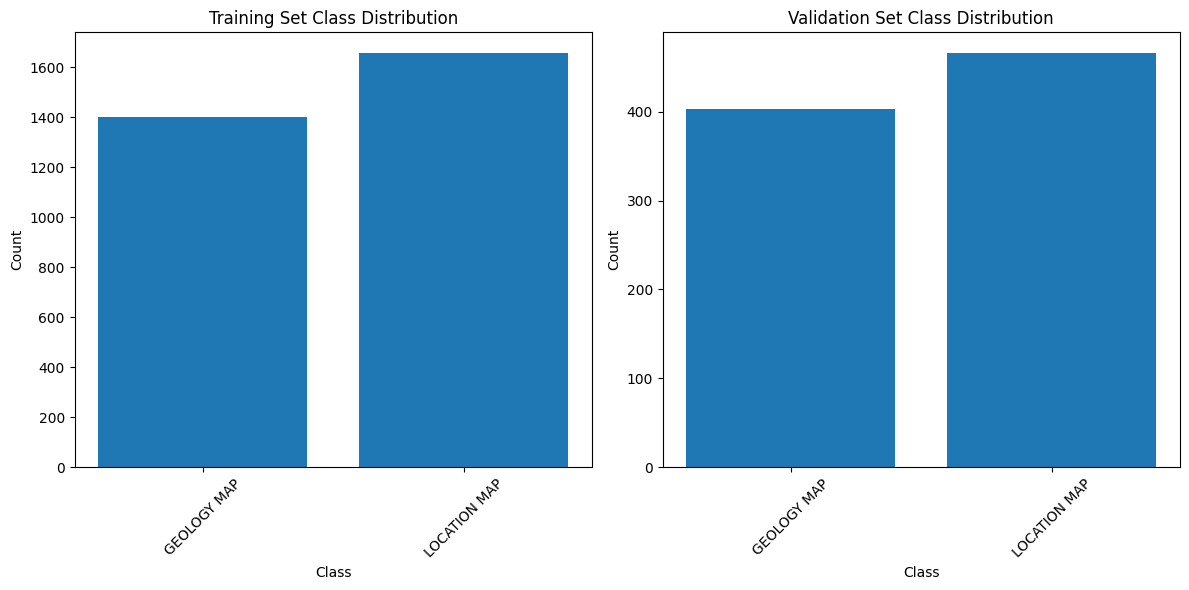

In [12]:
from collections import Counter

train_class_counts = Counter([label for _, label in train_data])
test_class_counts = Counter([label for _, label in test_data])

# Print the class distribution for both training and testing sets
print("Training Set Class Distribution:")
for class_idx, count in train_class_counts.items():
    print(f"Class {train_data.classes[class_idx]}: {count} samples")

print("\nTest Set Class Distribution:")
for class_idx, count in test_class_counts.items():
    print(f"Class {test_data.classes[class_idx]}: {count} samples")



# Training class distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(train_data.classes, train_class_counts.values())
plt.title("Training Set Class Distribution")
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

# validation class distribution
plt.subplot(1, 2, 2)
plt.bar(test_data.classes, test_class_counts.values())
plt.title("Validation Set Class Distribution")
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()

In [ ]:
classes = train_data.classes
class_dict = train_data.class_to_idx
print(classes,class_dict)

['GEOLOGY MAP', 'LOCATION MAP'] {'GEOLOGY MAP': 0, 'LOCATION MAP': 1}


In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(
  train_data,
  batch_size=BATCH_SIZE,
  shuffle=True
)
test_dataloader = DataLoader(
  test_data,
  batch_size=BATCH_SIZE,
  shuffle=False
)

print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Length of train_dataloader: 96 batches of 32
Length of test_dataloader: 28 batches of 32


In [ ]:
train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.size(),train_labels_batch.size()

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

In [ ]:
from torch import nn
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [ ]:
class Model_0(nn.Module):
  def __init__(self,input_shape:int,hidden_units:int,output_shape:int):
    super().__init__()
    self.conv_block1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block2 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )
    self.conv_block3 = nn.Sequential(
        nn.Conv2d(in_channels= hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding=1),
        nn.ReLU(),
        nn.BatchNorm2d(hidden_units),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels = hidden_units,
                  kernel_size = 3,
                  stride=1,
                  padding = 1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )

    self.classfier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=28*28*hidden_units,
                  out_features= hidden_units),
        nn.Linear(in_features=hidden_units,
                  out_features= output_shape)
    )


  def forward(self,x):
    x = self.conv_block1(x)
    x = self.conv_block2(x)
    x = self.conv_block3(x)
    x = self.classfier(x)
    return x

In [ ]:
mod = Model_0(input_shape=3,hidden_units=30,output_shape=1)
mod.to(device)

Model_0(
  (conv_block1): Sequential(
    (0): Conv2d(3, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(30, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3)

In [ ]:
rand_img = torch.rand(3, 224, 224).to(device)
mod(rand_img.unsqueeze(0))


tensor([[-0.1719]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
from timeit import default_timer as timer
def print_training_time(start_time:float,end_time:float,device:torch.device = None) -> float:
  """ Shows the training time of the model on CPU/GPU"""
  total_train_time =  end_time-start_time
  print(f"Total Training time on {device} is {total_train_time // 60} minutes {(total_train_time % 60):.3f} seconds")


In [ ]:

def accuracy_fn(y_true:torch.Tensor,y_pred:torch.Tensor) -> float:

  y_true,y_pred = y_true.to(device),y_pred.to(device)
  corr_vals = torch.eq(y_true,y_pred).sum().item()
  acc = (corr_vals / len(y_pred)) * 100
  return acc

In [ ]:
from torch.optim.lr_scheduler import StepLR
loss_func = nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adagrad(mod.parameters(),lr=0.001)
optimizer = torch.optim.SGD(mod.parameters(),lr=0.0001,nesterov=True,momentum=0.955)
# scheduler = StepLR(optimizer, step_size = 15,gamma=0.1)

In [ ]:
def training(model:torch.nn.Module,train_dataloader:torch.utils.data.DataLoader,loss_func:torch.nn.Module,accuracy_fn,device:torch.device):
  train_loss = 0
  train_acc = 0
  for batch,(X,y) in enumerate(train_dataloader):
    X,y = X.to(device),y.to(device)
    y_logits= mod(X).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))
    loss = loss_func(y_logits,y.float())
    train_loss += loss
    train_acc += accuracy_fn(y,y_pred)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  train_loss /= len(train_dataloader)
  train_acc /= len(train_dataloader)
  print(f"Train Loss: {train_loss:.4f} | Train Accuracy :{train_acc:.2f} %\n")

In [ ]:
def testing(model:torch.nn.Module,test_dataloader:torch.utils.data.DataLoader,loss_func:torch.nn.Module,accuracy_fn,device:torch.device):
  test_loss = 0
  test_acc = 0
  model.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      X,y = X.to(device),y.to(device)
      test_logits = model(X).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits))
      test_loss += loss_func(test_logits,y.float())
      test_acc += accuracy_fn(y,test_pred)

    test_loss /= len(test_dataloader)
    test_acc /= len(test_dataloader)
    print(f"Test Loss: {test_loss:.4f} | Test Accuracy :{test_acc:.2f}%\n")
    return test_acc


In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)

torch.cuda.manual_seed(42)
start_time = timer()
accuracy_final = 0.0
epochs = 25
for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch+1}")
  training(mod,train_dataloader,loss_func,accuracy_fn,device)
  accuracy_epoch = testing(mod,test_dataloader,loss_func,accuracy_fn,device)
  if accuracy_epoch > accuracy_final:
    accuracy_final = accuracy_epoch
    best_model_state = mod.state_dict()

print(f"Best validation accuracy : {accuracy_final}")
end_time  = timer()
print_training_time(start_time=start_time,end_time=end_time,device=device)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1
Train Loss: 0.4315 | Train Accuracy :79.14 %

Test Loss: 0.4479 | Test Accuracy :78.53%

Epoch: 2
Train Loss: 0.4241 | Train Accuracy :80.33 %

Test Loss: 0.4369 | Test Accuracy :79.31%

Epoch: 3
Train Loss: 0.4156 | Train Accuracy :80.43 %

Test Loss: 0.4406 | Test Accuracy :79.53%

Epoch: 4
Train Loss: 0.4144 | Train Accuracy :81.20 %

Test Loss: 0.4437 | Test Accuracy :78.30%

Epoch: 5
Train Loss: 0.4124 | Train Accuracy :80.48 %

Test Loss: 0.4387 | Test Accuracy :79.75%

Epoch: 6
Train Loss: 0.4044 | Train Accuracy :81.78 %

Test Loss: 0.4382 | Test Accuracy :78.75%

Epoch: 7
Train Loss: 0.4134 | Train Accuracy :80.85 %

Test Loss: 0.4515 | Test Accuracy :79.87%

Epoch: 8
Train Loss: 0.4105 | Train Accuracy :81.30 %

Test Loss: 0.4500 | Test Accuracy :79.31%

Epoch: 9
Train Loss: 0.4144 | Train Accuracy :80.85 %

Test Loss: 0.4578 | Test Accuracy :78.86%

Epoch: 10
Train Loss: 0.4138 | Train Accuracy :80.59 %

Test Loss: 0.4372 | Test Accuracy :79.20%

Epoch: 11
Train Los

In [ ]:

from pathlib import Path
# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "geomapclassify.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=mod.state_dict(),
           f=MODEL_SAVE_PATH)


Saving model to: models/geomapclassify.pth


Predictions on unseen test dataset

In [ ]:
test_dataset = datasets.ImageFolder(root=path/"test", transform=test_transform)

# Create DataLoader
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
mod.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = mod(X)

    y_pred = torch.round(torch.sigmoid(y_logit))
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
  # Concatenate list of predictions into a tensor
  y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
!pip install -q torchmetrics
!pip install -q mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 927.3/927.3 kB 49.3 MB/s eta 0:00:00


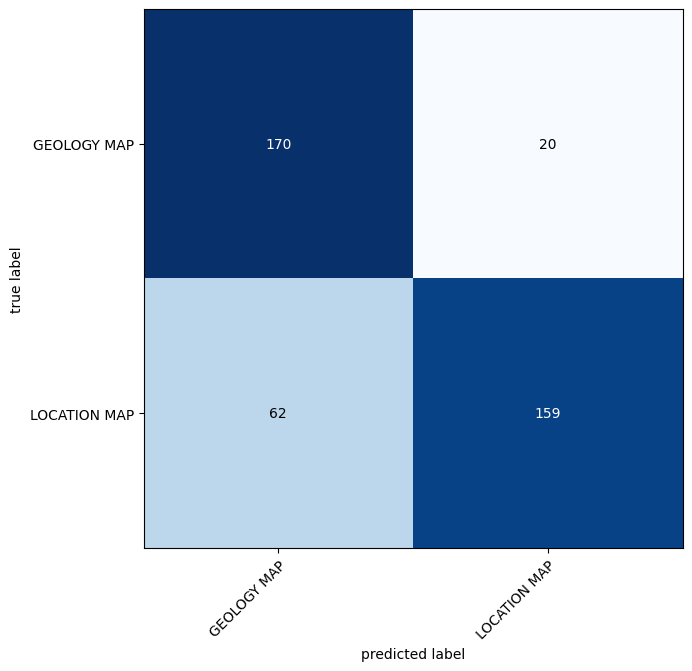

In [ ]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(classes), task='binary')
confmat_tensor = confmat(preds=y_pred_tensor.squeeze(),
                         target=torch.tensor(test_dataset.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=classes, # turn the row and column labels into class names
    figsize=(10, 7));